In [3]:
# !pip install weaviate-client
# !pip install llama_index==0.9.14
# !pip install llama_index==0.9.24
# !pip install openai
# !pip install --upgrade pydantic==1.10.12 typing-extensions==4.5.0
# !pip install fastcore

In [4]:
# !pip install typing-extensions==4.7

In [5]:
import os
import sys
import logging
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from configparser import ConfigParser

from llama_index.vector_stores import WeaviateVectorStore
from llama_index.schema import TextNode, NodeRelationship, RelatedNodeInfo
from llama_index import VectorStoreIndex, StorageContext
from llama_index import StorageContext, load_index_from_storage
from llama_index import get_response_synthesizer
from llama_index.indices.postprocessor import SimilarityPostprocessor, PrevNextNodePostprocessor
from llama_index.retrievers import VectorIndexRetriever
from llama_index.query_engine import RetrieverQueryEngine
from llama_index.indices.vector_store.retrievers import (
    VectorIndexAutoRetriever,
)
from llama_index.selectors.llm_selectors import (
    LLMSingleSelector,
    LLMMultiSelector,
)
from llama_index.selectors.pydantic_selectors import (
    PydanticMultiSelector,
    PydanticSingleSelector,
)
from llama_index.agent import AgentRunner
from llama_index.agent import OpenAIAgent
from llama_index.tools import FunctionTool
from llama_index.vector_stores.types import MetadataInfo, VectorStoreInfo
from llama_index import ServiceContext
from llama_index.llms import OpenAI as OpenAILLama
from llama_index.embeddings import OpenAIEmbedding, HuggingFaceEmbedding
from llama_index import download_loader

import openai
import weaviate
from weaviate import EmbeddedOptions

pd.set_option('display.max_colwidth',-1)

/tmp/ipykernel_1309/3307341420.py:42: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth',-1)


In [6]:
import nest_asyncio
nest_asyncio.apply()

In [7]:
from llama_index.llama_pack import download_llama_pack

download_llama_pack(
    "LLMCompilerAgentPack",
    "./agent_pack",
    skip_load=True,
    # leave the below line commented out if using the notebook on main
    # llama_hub_url="https://raw.githubusercontent.com/run-llama/llama-hub/jerry/add_llm_compiler_pack/llama_hub"
)
from agent_pack.step import LLMCompilerAgentWorker

/usr/local/lib/python3.9/dist-packages/pkg_resources/_vendor/jaraco/text/__init__.py:593: ResourceWarning: unclosed file <_io.TextIOWrapper name='agent_pack/requirements.txt' mode='r' encoding='UTF-8'>
  for item in lines:


# Configuration

## Set logging

In [8]:
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logging.getLogger().addHandler(logging.StreamHandler(stream=sys.stdout))

## OpenAI config

In [9]:
config=ConfigParser()
config.read('conf/conf.ini')
os.environ["OPENAI_API_KEY"] = config['openai']['apikey']

## Conf for LLM and embedding model

In [10]:
llm = OpenAILLama(model="gpt-3.5-turbo", temperature=0.1)
embed_model=OpenAIEmbedding() 

## Query engine/retriever conf

In [11]:
#retriever max top results and similarity top k 
max_top_k =100
similarity_top_k=100
#cosine sim under which returned nodes are not considered when giving an answer
similarity_cutoff=0.7

# Data

## Load data (text is already embedded)

In [6]:
#texts with metadata
# df=pd.read_excel('data/riigikogu_w_meta/data_sub.xlsx')
df=pd.read_excel('data/riigikogu_w_meta/data_all.xlsx')
df.shape

/usr/lib/python3/dist-packages/openpyxl/compat/numbers.py:41: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  numpy.float,


(410335, 23)

In [7]:
df.columns

Index(['heading', 'speaker', 'index_pk', 'index_snd', 'year', 'month', 'day',
       'time', 'text_wo_punct', 'date', 'koosseis', 'ntoks', 'text_splitted',
       'ntoks_splitted', 'doc_id', 'topic_id', 'topic_prob', 'Name',
       'cluster_name', 'cluster_name_very_high', 'topic_reduce_outliers',
       'Name_red_outliers', 'fation'],
      dtype='object')

In [8]:
#embeddings, NB! row order must be same as in df!
# embs_ar=np.load('data/riigikogu_w_meta/embs.npy', allow_pickle=True)
embs_ar=np.load('data/riigikogu_w_meta/embs_all.npy', allow_pickle=True)
embs_ar.shape

(410335,)

## Create nodes

In [9]:
df=df.rename(columns={'Name':'topic', 'Name_red_outliers':'topic_red_outliers', 'fation':'faction', 'text_splitted':'text'})
df.columns

Index(['heading', 'speaker', 'index_pk', 'index_snd', 'year', 'month', 'day',
       'time', 'text_wo_punct', 'date', 'koosseis', 'ntoks', 'text',
       'ntoks_splitted', 'doc_id', 'topic_id', 'topic_prob', 'topic',
       'cluster_name', 'cluster_name_very_high', 'topic_reduce_outliers',
       'topic_red_outliers', 'faction'],
      dtype='object')

In [10]:
metadata_cols=['heading', 'speaker', 'index_pk',
       'index_snd', 'year', 'month', 'day', 'time', 'date', 'koosseis',
       'ntoks_splitted', 'doc_id', 'topic_prob',
       'topic', 'topic_red_outliers', 'faction']

def create_nodes(df, embs_ar, metadata_cols):
    nodes = []
    for idx, sample in df.iterrows():
        metadata=dict()
        for meta_key in metadata_cols:
            if not pd.isna(sample[meta_key]):
                metadata[meta_key]=sample[meta_key]
        node = TextNode(
            text=sample['text'],
            metadata=metadata
        )
        node.embedding=embs_ar[idx]
        
        if idx>0:
            node.relationships[NodeRelationship.PREVIOUS] = RelatedNodeInfo(
                node_id=nodes[-1].node_id
            )
            if idx <(df.shape[0]-1):
                nodes[-1].relationships[NodeRelationship.NEXT] = RelatedNodeInfo(
                node_id=node.node_id
            )
        nodes.append(node)
    return nodes

nodes=create_nodes(df, embs_ar, metadata_cols)

## Describe metadata - needed for LLM to later use it for filtering

In [12]:
#describe metadata
vector_store_info = VectorStoreInfo(
    content_info="segment text from Riigikogu stenogram",
    metadata_info=[
        MetadataInfo(
            name="heading",
            type="str",
            description=(
                "Heading of the stenogram"
            ),
        ),
        MetadataInfo(
            name="speaker",
            type="str",
            description=(
                "Name of the speaker of the segment text"
            ),
        ),
        MetadataInfo(
            name="index_pk",
            type="str",
            description=(
                "Index of a päevakorrapunkt"
            ),
        ),
        MetadataInfo(
            name="year",
            type="int",
            description=(
                "Year when the segment was spoken"
            ),
        ),
        MetadataInfo(
            name="month",
            type="int",
            description=(
                "Month when the segment was spoken"
            ),
        ),
        MetadataInfo(
            name="day",
            type="int",
            description=(
                "Day when the segment was spoken"
            ),
        ),
        MetadataInfo(
            name="time",
            type="str",
            description=(
                "Time when the segment was spoken"
            ),
        ),
        MetadataInfo(
            name="date",
            type="str",
            description=(
                "Date when the segment was spoken, in format YYYY-MM-DD"
            ),
        ),
        MetadataInfo(
            name="koosseis",
            type="str",
            description=(
                "Number Riigikogu kossseis in which segment was spoken"
            ),
        ),
        MetadataInfo(
            name="ntoks_splitted",
            type="int",
            description=(
                "Number of tokens/words in segment text"
            ),
        ),
        MetadataInfo(
            name="doc_id",
            type="int",
            description=(
                "Segment text id"
            ),
        ),
        MetadataInfo(
            name="topic_prob",
            type="float",
            description=(
                "Probability of a topic"
            ),
        ),
        MetadataInfo(
            name="topic",
            type="str",
            description=(
                "Name of the topic"
            ),
        ),
        MetadataInfo(
            name="topic_red_outliers",
            type="str",
            description=(
                "Name of the topic if outliers have been reduced"
            ),
        ),
        MetadataInfo(
            name="faction",
            type="str",
            description=(
                "Speaker faction"
            ),
        ),
    ],
)

# Vector store and index

## Create vector store

In [13]:
client = weaviate.Client(
    embedded_options=EmbeddedOptions(persistence_data_path = '/notebooks/rag_advanced/weaviate_storage/',
                                     binary_path= '/notebooks/rag_advanced/weaviate_storage/'),
    # additional_headers={
    #     "X-OpenAI-Api-BaseURL": os.environ['OPENAI_API_BASE'],
    #     "X-OpenAI-Api-Key": openai.api_key,  # Replace this with your actual key
    # }
)
print(f"Client created? {client.is_ready()}")

Started /notebooks/rag_advanced/weaviate_storage/: process ID 1345
Client created? True


{"action":"startup","default_vectorizer_module":"none","level":"info","msg":"the default vectorizer modules is set to \"none\", as a result all new schema classes without an explicit vectorizer setting, will use this vectorizer","time":"2024-01-01T14:34:30Z"}
{"action":"startup","auto_schema_enabled":true,"level":"info","msg":"auto schema enabled setting is set to \"true\"","time":"2024-01-01T14:34:30Z"}
{"level":"info","msg":"No resource limits set, weaviate will use all available memory and CPU. To limit resources, set LIMIT_RESOURCES=true","time":"2024-01-01T14:34:30Z"}
{"level":"warning","msg":"Multiple vector spaces are present, GraphQL Explore and REST API list objects endpoint module include params has been disabled as a result.","time":"2024-01-01T14:34:30Z"}
{"action":"grpc_startup","level":"info","msg":"grpc server listening at [::]:50060","time":"2024-01-01T14:34:30Z"}
{"action":"restapi_management","level":"info","msg":"Serving weaviate at http://127.0.0.1:8079","time":"202

In [10]:
#if you have instantiated this already you run this 2x on command line to remove existing vector store
# !rm -rf /root/.local/share/weaviate/riigikogu_meta_index

{"action":"lsm_recover_from_active_wal","class":"Riigikogu_meta_index","index":"riigikogu_meta_index","level":"warning","msg":"active write-ahead-log found. Did weaviate crash prior to this? Trying to recover...","path":"/notebooks/rag_advanced/weaviate_storage/riigikogu_meta_index/LKP5PZ6R90pi/lsm/objects/segment-1704117588802083481.wal","shard":"LKP5PZ6R90pi","time":"2024-01-01T14:02:37Z"}
{"action":"lsm_recover_from_active_wal_success","class":"Riigikogu_meta_index","index":"riigikogu_meta_index","level":"info","msg":"successfully recovered from write-ahead-log","path":"/notebooks/rag_advanced/weaviate_storage/riigikogu_meta_index/LKP5PZ6R90pi/lsm/objects/segment-1704117588802083481.wal","shard":"LKP5PZ6R90pi","time":"2024-01-01T14:02:37Z"}
{"action":"lsm_recover_from_active_wal","class":"Riigikogu_meta_index","index":"riigikogu_meta_index","level":"warning","msg":"active write-ahead-log found. Did weaviate crash prior to this? Trying to recover...","path":"/notebooks/rag_advanced/w

## Create an index

In [14]:
def create_index(client, nodes, llm, embed_model, index_name="Riigikogu_meta_index", text_key="text"):
    vector_store = WeaviateVectorStore(weaviate_client = client, index_name=index_name, text_key=text_key)
    # setting up the storage for the embeddings
    storage_context = StorageContext.from_defaults(vector_store = vector_store)
    service_context = ServiceContext.from_defaults(
        llm=llm, embed_model=embed_model
    )
    # set up the index
    index = VectorStoreIndex(nodes, storage_context = storage_context, service_context=service_context)
    return index, vector_store

index, vector_store=create_index(client, nodes, llm, embed_model)

{"action":"read_disk_use","level":"warning","msg":"disk usage currently at 80.04%, threshold set to 80.00%","path":"/notebooks/rag_advanced/weaviate_storage/","time":"2024-01-01T12:56:35Z"}
{"action":"lsm_recover_from_active_wal","class":"Riigikogu_meta_index","index":"riigikogu_meta_index","level":"warning","msg":"active write-ahead-log found. Did weaviate crash prior to this? Trying to recover...","path":"/notebooks/rag_advanced/weaviate_storage/riigikogu_meta_index/LKP5PZ6R90pi/lsm/objects/segment-1704032861624301713.wal","shard":"LKP5PZ6R90pi","time":"2024-01-01T12:56:36Z"}
{"action":"lsm_recover_from_active_wal_success","class":"Riigikogu_meta_index","index":"riigikogu_meta_index","level":"info","msg":"successfully recovered from write-ahead-log","path":"/notebooks/rag_advanced/weaviate_storage/riigikogu_meta_index/LKP5PZ6R90pi/lsm/objects/segment-1704032861624301713.wal","shard":"LKP5PZ6R90pi","time":"2024-01-01T12:56:36Z"}
{"action":"lsm_recover_from_active_wal","class":"Riigiko

## Save index to disk

In [15]:
index.storage_context.persist("riigikogu_meta_index")

## If needed reload index from disk

In [23]:
# # Rebuild storage context
# storage_context = StorageContext.from_defaults(persist_dir="riigikogu_meta_index")

# # Load index from the storage context
# index2 = load_index_from_storage(storage_context)

## Or load index without adding same nodes again, read it from the disk

In [14]:
def load_index(client, index_name="Riigikogu_meta_index", text_key="text", persist_dir='riigikogu_meta_index/'):
    vector_store = WeaviateVectorStore(weaviate_client = client, index_name=index_name, text_key=text_key)
    storage_context = StorageContext.from_defaults(vector_store=vector_store, persist_dir=persist_dir)
    index = load_index_from_storage(storage_context)
    return index

index=load_index(client)

INFO:llama_index.indices.loading:Loading all indices.
Loading all indices.


## Define query engine - that queries nodes and synthesizes/summarizes answers from them

In [15]:
#query engine and retriver will be used in tools
def create_query_engine(index, max_top_k=20, similarity_top_k=20, similarity_cutoff=0.7, 
                        vector_store_info=None, synthesizer_response_mode="tree_summarize",
                        retriever_uses_meta=True, return_retriever=True):
    if not retriever_uses_meta:
        #this uses only text information
        retriever = VectorIndexRetriever(
            index=index,
            similarity_top_k=similarity_top_k,
        )
    else:
        #this one should automatically use metadata
        retriever = VectorIndexAutoRetriever(
            index, vector_store_info=vector_store_info,
            max_top_k=max_top_k,
            similarity_top_k=similarity_top_k
        )

    # Set up the synthesizer
    my_synthesizer = get_response_synthesizer(response_mode=synthesizer_response_mode)
    
    query_engine = RetrieverQueryEngine(
        retriever=retriever,
        response_synthesizer=my_synthesizer,
        node_postprocessors=[
            SimilarityPostprocessor(similarity_cutoff=similarity_cutoff)
        ]
    )
    if return_retriever:
        return query_engine, retriever
    return query_engine

query_engine, retriever=create_query_engine(index, max_top_k, 
                                            similarity_top_k, similarity_cutoff, 
                                            vector_store_info)

# Tools that do the aggregation 

## Define functions/tools that will do heavy lifting. Functions will use retrieved nodes to aggregate data for answers

In [25]:
#each function uses query engine/retriever to get textual answer or nodes and genertae answer based on the nodes
#you can add more functions, just add informative description and later turn it into a tool

def count_of_events(text: str) -> str:
    """Given a text string finds number of events in database and returns the answer."""
    nodes=retriever.retrieve(text)
    return f"Number of events containing '{text}' is: {len(nodes)}"


def changes_in_events(text_period1: str, text_period2:str) -> str:
    """Compares changes in events in two time periods. Makes two queries: text_period1 uses origial text but filters for period 1,
    text_period2 uses origial text but filters for period 2. """
    
    nodes_period1=retriever.retrieve(text_period1)
    nodes_period2=retriever.retrieve(text_period2)
    change_factor=len(nodes_period2)/len(nodes_period1)
    return f"Most significant change is that number of events changes by a factor of {change_factor}"

def show_sample_events(text: str, n:int=100) -> str:
    """Given a text string finds events and returns n of them"""
    nodes=retriever.retrieve(text)
    
    return f"Events which contain '{text}' are: {[t.text for t in nodes[:n]]}"

def plot_events_timeline(text: str, n:int=100, time_granularity:str='day') -> str:
    """Given a text string finds events and their count distribution on timeline and plots it.
    'n' is the number of nodes to consider, by default 100
    'time_granularity' is granularity of time for plotting, must be one of: 'day', 'week' or 'month'
    Returns message plot is generated and matplotlib plot object"""
    
    if time_granularity not in ['day', 'week', 'month']:
        time_granularity='day'
        
    nodes=retriever.retrieve(text)
    df_nodes=pd.DataFrame([n.to_dict()['node']|n.to_dict()['node']['metadata'] for n in nodes])
    plot=df_nodes.groupby(['year', time_granularity])['id_'].count().unstack().T.plot()
    plt.savefig('temp/plot.png')
    plt.show()
    
    return "plot is generated and visible here:temp/plot.png", plot

def plot_events_metadata_distribution(text: str, metadata_key:str, n:int=100) -> str:
    """Given a text string finds events and counts their metadata_key distribution and plots it.
    'n' is the number of nodes to consider, by default 100
    'metadata_key' is metadata column that is used for dividing data into groups"""
        
    nodes=retriever.retrieve(text)
    df_nodes=pd.DataFrame([n.to_dict()['node']|n.to_dict()['node']['metadata'] for n in nodes])
    plot=df_nodes[metadata_key].value_counts().plot(kind='barh')
    plt.savefig('temp/plot.png')
    plt.show()
    
    return "plot is generated and visible here:temp/plot.png"

def summarize_texts(query_text: str, n:int=100) -> str:
    """Given a query_text string finds events and summarizes them. Query atring should be same as original input from user. 
    Uses LLM to summarize texts not metadata"""
    response=query_engine.query(query_text)
    
    return f"Summary is: {response.response}"

count_of_events_tool = FunctionTool.from_defaults(fn=count_of_events)
changes_in_events_tool = FunctionTool.from_defaults(fn=changes_in_events)
show_sample_events_tool = FunctionTool.from_defaults(fn=show_sample_events)
plot_events_timeline_tool = FunctionTool.from_defaults(fn=plot_events_timeline)
plot_events_metadata_distribution_tool = FunctionTool.from_defaults(fn=plot_events_metadata_distribution)
summarize_texts_tool = FunctionTool.from_defaults(fn=summarize_texts)

tools=[count_of_events_tool, changes_in_events_tool, show_sample_events_tool, plot_events_timeline_tool, 
       plot_events_metadata_distribution_tool, summarize_texts_tool]

# Create agent

In [22]:
agent = OpenAIAgent.from_tools(tools, verbose=True)
 
def chat(agent, text):
    chat_resp=agent.chat(text)
    return chat_resp.response

# Chat with agent

## High level usage

In [16]:
#here we can compare chat result with original data
df[(df.speaker=='Maria Jufereva-Skuratovski')].month.value_counts()

NameError: name 'df' is not defined

In [21]:
df[(df.speaker=='Maria Jufereva-Skuratovski')&(df.month==6)].day.value_counts()

19    26
12    7 
3     6 
14    5 
16    3 
1     2 
8     2 
20    2 
7     1 
Name: day, dtype: int64

In [25]:
chat(agent, "How many segments there are where speaker is 'Maria Jufereva-Skuratovski' and month is 9?")

Added user message to memory: How many segments there are where speaker is 'Maria Jufereva-Skuratovski' and month is 9?
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
=== Calling Function ===
Calling function: count_of_events with args: {
  "text": "speaker: 'Maria Jufereva-Skuratovski' AND month: 9"
}
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:llama_index.indices.vector_store.retrievers.auto_retriever.auto_retriever:Using query str: 
Using query str: 
INFO:llama_index.indices.vector_store.retrievers.auto_retriever.auto_retriever:Using filters: [('speaker', '==', 'Maria Jufereva-Skuratovski'), ('month', '==', 9)]
Using filters: [('speaker', '==', 'Maria Jufereva-Skuratovski'), ('month', '==', 9)]
INFO:llama_index.indices.vector_store

"There are 10 segments where the speaker is 'Maria Jufereva-Skuratovski' and the month is 9."

STARTING TURN 1
---------------

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
=== Calling Function ===
Calling function: plot_events_timeline with args: {
  "text": "speaker: 'Maria Jufereva-Skuratovski' AND month: 6",
  "time_granularity": "day"
}
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:llama_index.indices.vector_store.retrievers.auto_retriever.auto_retriever:Using query str: 
Using query str: 
INFO:llama_index.indices.vector_store.retrievers.auto_retriever.auto_retriever:Using filters: {'speaker': 'Maria Jufereva-Skuratovski', 'month': 6}
Using filters: {'speaker': 'Maria Jufereva-Skuratovski', 'month': 6}
INFO:llama_index.indices.vector_store.retrievers.auto_retriever.auto_retriever:Using top_k: 100
Using top_k: 100


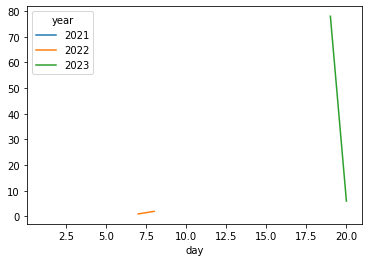

Got output: ('plot is generated', <AxesSubplot:xlabel='day'>)

STARTING TURN 2
---------------

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


"Here is the plot showing the count of segments on a daily basis where the speaker is 'Maria Jufereva-Skuratovski' and the month is 6."

In [23]:
chat(agent, "Plot ma a count of segments on a daily basis where speaker is 'Maria Jufereva-Skuratovski' and month is 6")

In [51]:
chat(agent, "How many segments there are where speaker is 'Tõnis Mölder'?")

STARTING TURN 1
---------------

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
=== Calling Function ===
Calling function: count_of_events with args: {
  "text": "speaker:Tõnis Mölder"
}
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:llama_index.indices.vector_store.retrievers.auto_retriever.auto_retriever:Using query str: 
Using query str: 
INFO:llama_index.indices.vector_store.retrievers.auto_retriever.auto_retriever:Using filters: {'speaker': 'Tõnis Mölder'}
Using filters: {'speaker': 'Tõnis Mölder'}
INFO:llama_index.indices.vector_store.retrievers.auto_retriever.auto_retriever:Using top_k: 20
Using top_k: 20
Got output: Number of events containing 'speaker:Tõnis Mölder' is: 20

STARTING TURN 2
---------------

INFO:httpx:HTTP Request

"There are 20 segments where the speaker is 'Tõnis Mölder'."

In [70]:
chat(agent, "How many segments there are where speaker is 'tõnis mölder'?")

STARTING TURN 1
---------------

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
=== Calling Function ===
Calling function: count_of_events with args: {
"text": "segments where speaker is 'tõnis mölder'"
}
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:llama_index.indices.vector_store.retrievers.auto_retriever.auto_retriever:Using query str: 
Using query str: 
INFO:llama_index.indices.vector_store.retrievers.auto_retriever.auto_retriever:Using filters: {'speaker': 'tõnis mölder'}
Using filters: {'speaker': 'tõnis mölder'}
INFO:llama_index.indices.vector_store.retrievers.auto_retriever.auto_retriever:Using top_k: 100
Using top_k: 100
Got output: Number of events containing 'segments where speaker is 'tõnis mölder'' is: 38

STARTING TURN 2


"There are 38 segments where the speaker is 'tõnis mölder'."

### See if can separate metadata vs finding itself topics

STARTING TURN 1
---------------

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
=== Calling Function ===
Calling function: plot_events_metadata_distribution with args: {
  "text": "segments",
  "metadata_key": "topic",
  "n": 100
}
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:llama_index.indices.vector_store.retrievers.auto_retriever.auto_retriever:Using query str: segments
Using query str: segments
INFO:llama_index.indices.vector_store.retrievers.auto_retriever.auto_retriever:Using filters: {}
Using filters: {}
INFO:llama_index.indices.vector_store.retrievers.auto_retriever.auto_retriever:Using top_k: 100
Using top_k: 100
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://ap

{"action":"startup","default_vectorizer_module":"none","level":"info","msg":"the default vectorizer modules is set to \"none\", as a result all new schema classes without an explicit vectorizer setting, will use this vectorizer","time":"2024-01-01T13:49:52Z"}
{"action":"startup","auto_schema_enabled":true,"level":"info","msg":"auto schema enabled setting is set to \"true\"","time":"2024-01-01T13:49:52Z"}
{"level":"info","msg":"No resource limits set, weaviate will use all available memory and CPU. To limit resources, set LIMIT_RESOURCES=true","time":"2024-01-01T13:49:52Z"}
{"level":"warning","msg":"Multiple vector spaces are present, GraphQL Explore and REST API list objects endpoint module include params has been disabled as a result.","time":"2024-01-01T13:49:53Z"}
{"action":"grpc_startup","level":"info","msg":"grpc server listening at [::]:50060","time":"2024-01-01T13:49:53Z"}
{"action":"restapi_management","level":"info","msg":"Serving weaviate at http://127.0.0.1:8079","time":"202

Got output: Error: Filter is missing required fields `path` or `operands`. Given: {}

STARTING TURN 2
---------------



{"action":"read_disk_use","level":"warning","msg":"disk usage currently at 80.06%, threshold set to 80.00%","path":"/notebooks/rag_advanced/weaviate_storage/","time":"2024-01-01T13:49:53Z"}


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
=== Calling Function ===
Calling function: plot_events_metadata_distribution with args: {
  "text": "segments.speaker:'Maria Jufereva-Skuratovski' AND segments.month:9",
  "metadata_key": "topic",
  "n": 100
}


{"level":"info","msg":"Completed loading shard riigikogu_meta_index_LKP5PZ6R90pi in 1.160589598s","time":"2024-01-01T13:49:55Z"}


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:llama_index.indices.vector_store.retrievers.auto_retriever.auto_retriever:Using query str: 
Using query str: 
INFO:llama_index.indices.vector_store.retrievers.auto_retriever.auto_retriever:Using filters: {'speaker': 'Maria Jufereva-Skuratovski', 'month': 9}
Using filters: {'speaker': 'Maria Jufereva-Skuratovski', 'month': 9}
INFO:llama_index.indices.vector_store.retrievers.auto_retriever.auto_retriever:Using top_k: 100
Using top_k: 100


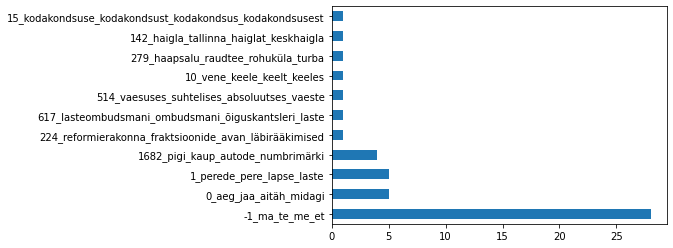

Got output: plot is generated

STARTING TURN 3
---------------

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


"Here is the topic distribution of segments where the speaker is 'Maria Jufereva-Skuratovski' and the month is 9:\n\n![Topic Distribution](plot.png)"

{"action":"hnsw_vector_cache_prefill","count":502200,"index_id":"main","level":"info","limit":1000000000000,"msg":"prefilled vector cache","time":"2024-01-01T13:50:08Z","took":13744156868}
{"action":"read_disk_use","level":"warning","msg":"disk usage currently at 80.06%, threshold set to 80.00%","path":"/notebooks/rag_advanced/weaviate_storage/","time":"2024-01-01T13:50:24Z"}
{"action":"read_disk_use","level":"warning","msg":"disk usage currently at 80.04%, threshold set to 80.00%","path":"/notebooks/rag_advanced/weaviate_storage/","time":"2024-01-01T13:52:24Z"}


In [29]:
chat(agent, "Plot me a topic distribution of topics of segments where speaker is 'Maria Jufereva-Skuratovski' and month is 9?")

In [51]:
chat(agent, "Please make a short summary of topics of segments where speaker is 'Maria Jufereva-Skuratovski' and month is 9?")

STARTING TURN 1
---------------

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


"I apologize for the inconvenience. Here is a short summary of the topics discussed in segments where the speaker is 'Maria Jufereva-Skuratovski' and the month is September (9):\n\n1. The presence of vehicles with Russian license plates in Estonia and the need to identify whether they are for commercial purposes or privately owned.\n2. The challenges faced by people with disabilities in society and the need for better support and employment opportunities.\n3. The increase in the number of teenagers and children seeking psychological assistance during the COVID-19 crisis and the importance of timely and adequate support.\n4. The need for a well-thought-out and transparent family policy in the country, highlighting the inconsistency in government actions regarding family benefits and the impact on families' well-being and trust in the government.\n\nPlease note that these summaries are based on a limited sample of events and may not capture the full range of topics discussed by Maria Juf

In [46]:
# response=query_engine.query("Please make a short summary of topics of segments where speaker is 'Maria Jufereva-Skuratovski' and month is 9?")
# response.response

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Using query str: 
Using filters: {'speaker': 'Maria Jufereva-Skuratovski', 'month': 9}
Using top_k: 100
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


'The topics of the segments where the speaker is Maria Jufereva-Skuratovski and the month is September are as follows:\n1. Segment 1: The topic is related to foreign policy and the issue of cars with Russian license plates in Estonia and the European Union.\n2. Segment 2: The topic is about the proposed amendment to the law on social benefits for disabled people and the employment opportunities for disabled individuals.\n3. Segment 3: The topic is about the increase in the number of teenagers and children needing psychological support during the COVID-19 crisis and the availability of assistance for them.\n4. Segment 4: The topic is about the proposed amendment to the law on family benefits and the inconsistency in government policies regarding family support.'

In [52]:
# chat(agent, "Please make a short overview of what speaker 'Maria Jufereva-Skuratovski' is talking about in texts where month is 9")

## See if two time period comparison works

In [54]:
chat(agent, "Please show most significant changes in events where speaker is 'Maria Jufereva-Skuratovski' by comparing months 6 and 9?")

STARTING TURN 1
---------------

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
=== Calling Function ===
Calling function: changes_in_events with args: {
  "text_period1": "speaker: 'Maria Jufereva-Skuratovski' and month: 6",
  "text_period2": "speaker: 'Maria Jufereva-Skuratovski' and month: 9"
}
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Using query str: 
Using filters: {'speaker': 'Maria Jufereva-Skuratovski', 'month': 6}
Using top_k: 100
Embedded weaviate wasn't listening on port 8079, so starting embedded weaviate again
Started /root/.cache/weaviate-embedded: process ID 532


{"action":"startup","default_vectorizer_module":"none","level":"info","msg":"the default vectorizer modules is set to \"none\", as a result all new schema classes without an explicit vectorizer setting, will use this vectorizer","time":"2023-12-29T09:36:17Z"}
{"action":"startup","auto_schema_enabled":true,"level":"info","msg":"auto schema enabled setting is set to \"true\"","time":"2023-12-29T09:36:17Z"}
{"level":"info","msg":"No resource limits set, weaviate will use all available memory and CPU. To limit resources, set LIMIT_RESOURCES=true","time":"2023-12-29T09:36:17Z"}
{"level":"warning","msg":"Multiple vector spaces are present, GraphQL Explore and REST API list objects endpoint module include params has been disabled as a result.","time":"2023-12-29T09:36:17Z"}
{"action":"grpc_startup","level":"info","msg":"grpc server listening at [::]:50060","time":"2023-12-29T09:36:17Z"}
{"action":"restapi_management","level":"info","msg":"Serving weaviate at http://127.0.0.1:8079","time":"202

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Using query str: 
Using filters: {'speaker': 'Maria Jufereva-Skuratovski', 'month': 9}
Using top_k: 100
Got output: Most significant change is that number of events changes by a factor of 0.17857142857142858

STARTING TURN 2
---------------

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


"The most significant change in events where the speaker is 'Maria Jufereva-Skuratovski' is that the number of events changes by a factor of 0.17857142857142858."

## Use agent directly without a wrapper function

In [61]:
chat_resp=agent.chat( "How many segments there are where speaker is 'Aleksei Jevgrafov'?")

STARTING TURN 1
---------------

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
=== Calling Function ===
Calling function: count_of_events with args: {
  "text": "speaker: 'Aleksei Jevgrafov'"
}
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Using query str: 
Using filters: {'speaker': 'Aleksei Jevgrafov'}
Using top_k: 100
Got output: Number of events containing 'speaker: 'Aleksei Jevgrafov'' is: 10

STARTING TURN 2
---------------

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [47]:
chat_resp.response

"There are 10 segments where the speaker is 'Aleksei Jevgrafov'."

In [48]:
chat_resp2=agent.chat( "What topics is speaker 'Aleksei Jevgrafov' talking about?")

STARTING TURN 1
---------------

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
=== Calling Function ===
Calling function: show_sample_events with args: {
"text": "segments where speaker is 'Aleksei Jevgrafov'",
"n": 5
}
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:llama_index.indices.vector_store.retrievers.auto_retriever.auto_retriever:Using query str: 
Using query str: 
Using query str: 
INFO:llama_index.indices.vector_store.retrievers.auto_retriever.auto_retriever:Using filters: {'speaker': 'Aleksei Jevgrafov'}
Using filters: {'speaker': 'Aleksei Jevgrafov'}
Using filters: {

In [50]:
print(chat_resp2.response)

Here are some topics that speaker 'Aleksei Jevgrafov' is talking about:

1. The use of the Estonian language in Narva and the lack of Estonian language services.
2. The closure of offices in certain districts and the impact on the local community.
3. The financial aspect of Estonian Post and the balance between profit-making and social aspects.
4. The reduction of post offices in Narva and the difficulties faced by elderly people.
5. The selection process for a special representative and the consideration of IVOL's proposals.

These are just a few examples. Speaker 'Aleksei Jevgrafov' may discuss other topics as well.


## Even lower level usage - see retrieved nodes

In [62]:
#check speaker value counts
df.speaker.value_counts()[70:80]

Helmen Kütt                             16
Raimond Kaljulaid                       16
Heljo Pikhof                            15
Eesti Vabariigi president Alar Karis    13
Karmen Joller                           13
Kadri Tali                              12
Marko Mihkelson                         11
Maris Lauri                             11
Signe Kivi                              11
Aleksei Jevgrafov                       10
Name: speaker, dtype: int64

In [71]:
nodes=retriever_meta.retrieve("How many segments there are where speaker is 'Aleksei Jevgrafov'?")

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:llama_index.indices.vector_store.retrievers.auto_retriever.auto_retriever:Using query str: 
Using query str: 
INFO:llama_index.indices.vector_store.retrievers.auto_retriever.auto_retriever:Using filters: {'speaker': 'Aleksei Jevgrafov'}
Using filters: {'speaker': 'Aleksei Jevgrafov'}
INFO:llama_index.indices.vector_store.retrievers.auto_retriever.auto_retriever:Using top_k: 100
Using top_k: 100


In [41]:
len(nodes)

10

STARTING TURN 1
---------------

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
=== Calling Function ===
Calling function: plot_events_timeline with args: {
  "text": "speaker:Aleksei Jevgrafov",
  "time_granularity": "day"
}
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:llama_index.indices.vector_store.retrievers.auto_retriever.auto_retriever:Using query str: 
Using query str: 
Using query str: 
INFO:llama_index.indices.vector_store.retrievers.auto_retriever.auto_retriever:Using filters: {'speaker': 'Aleksei Jevgrafov'}
Using filters: {'speaker': 'Aleksei Jevgrafov'}
Using filte

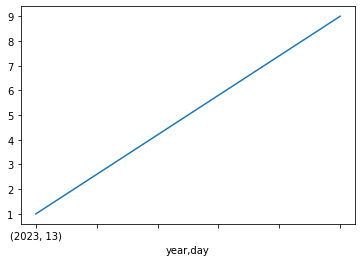

Got output: plot is generated

STARTING TURN 2
---------------

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [89]:
chat_resp3=agent.chat("Plot me a count of speaker 'Aleksei Jevgrafov' talked segments with a daily granularity")

STARTING TURN 1
---------------

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
=== Calling Function ===
Calling function: plot_events_timeline with args: {
  "text": "count_of_events(speaker:'Aleksei Jevgrafov')",
  "time_granularity": "month"
}
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:llama_index.indices.vector_store.retrievers.auto_retriever.auto_retriever:Using query str: count_of_events
Using query str: count_of_events
Using query str: count_of_events
INFO:llama_index.indices.vector_store.retrievers.auto_retriever.auto_retriever:Using filters: {'speaker': 'Aleksei Jevgr

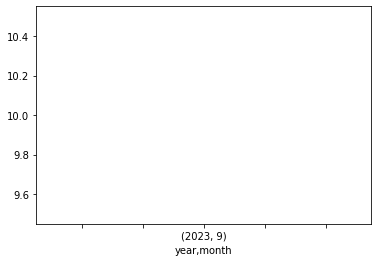

Got output: plot is generated

STARTING TURN 2
---------------

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [93]:
chat_resp3=agent.chat("Plot me a count of speaker 'Aleksei Jevgrafov' talked segments with a monthly granularity")

# LLM compiler agent

In [18]:
#source: https://github.com/run-llama/llama-hub/blob/main/llama_hub/llama_packs/agents/llm_compiler/llm_compiler.ipynb
callback_manager = llm.callback_manager

In [26]:
agent_worker = LLMCompilerAgentWorker.from_tools(
    tools, llm=llm, verbose=True, callback_manager=callback_manager
)
agent_comp = AgentRunner(agent_worker, callback_manager=callback_manager)

In [24]:
response = agent_comp.chat("How many segments there are where speaker is 'Maria Jufereva-Skuratovski' and month is 9?")

> Running step 41f2ccfa-60c4-4955-85d2-dee547a9222c for task fbee61e1-f22e-41ac-bffc-f3d975baf0be.
> Step count: 0
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
> Plan: 1. count_of_events("speaker:'Maria Jufereva-Skuratovski' AND month:9")
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:llama_index.indices.vector_store.retrievers.auto_retriever.auto_retriever:Using query str: 
Using query str: 
INFO:llama_index.indices.vector_store.retrievers.auto_retriever.auto_retriever:Using filters: [('speaker', '==', 'Maria Jufereva-Skuratovski'), ('month', '==', 9)]
Using filters: [('speaker', '==', 'Maria Jufereva-Skuratovski'), ('month', '==', 9)]
INFO:llama_index.indices.vector_store.retrievers.auto_retriever.auto_retriever:Using top_k: 10
Using

In [26]:
response

AgentChatResponse(response='10', sources=[], source_nodes=[])

> Running step cf34b1fd-2825-4a8b-9b2b-59f2ec63b1e9 for task c0d81462-6405-4740-bd7f-97d2e38cb533.
> Step count: 0
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
> Plan: 1. count_of_events("speaker:'Maria Jufereva-Skuratovski' AND month:6")
2. plot_events_timeline($1, time_granularity='day')
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:llama_index.indices.vector_store.retrievers.auto_retriever.auto_retriever:Using query str: 
Using query str: 
INFO:llama_index.indices.vector_store.retrievers.auto_retriever.auto_retriever:Using filters: [('speaker', '==', 'Maria Jufereva-Skuratovski'), ('month', '==', 6)]
Using filters: [('speaker', '==', 'Maria Jufereva-Skuratovski'), ('month', '==', 6)]
INFO:llama_index.indices.vector_store.retrievers

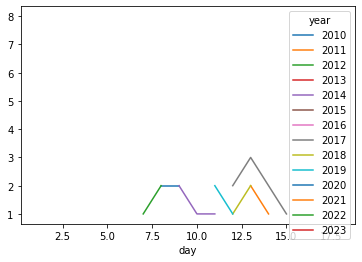

Ran task: plot_events_timeline. Observation: ('plot is generated and visible here:temp/plot.png', <AxesSubplot:xlabel='day'>)
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
> Thought: 
> Answer: finish(('plot is generated and visible here:temp/plot.png', <AxesSubplot:xlabel='day'>))


"finish(('plot is generated and visible here:temp/plot.png', <AxesSubplot:xlabel='day'>))"

In [27]:
chat(agent_comp, "Plot ma a count of segments on a daily basis where speaker is 'Maria Jufereva-Skuratovski' and month is 6")